In [2]:
# 전이 네트워크
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('./deep-learning/data/train', target_size=(150, 150), batch_size=5, class_mode='binary')
test_generator = test_datagen.flow_from_directory('./deep-learning/data/test', target_size=(150, 150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [4]:
# transfer 모델을 새로 만들자
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
transfer_model.trainable=False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [6]:
# 파인튜닝을 해야함
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, activation='sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss', patience=5)

In [8]:
history = finetune_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 19s 567ms/step - loss: 0.7131 - accuracy: 0.6062 - val_loss: 0.5674 - val_accuracy: 0.8167
Epoch 2/100
32/32 [==============================] - 20s 647ms/step - loss: 0.5615 - accuracy: 0.7250 - val_loss: 0.5001 - val_accuracy: 0.8500
Epoch 3/100
32/32 [==============================] - 20s 645ms/step - loss: 0.4853 - accuracy: 0.8125 - val_loss: 0.4189 - val_accuracy: 0.8833
Epoch 4/100
32/32 [==============================] - 20s 634ms/step - loss: 0.4150 - accuracy: 0.8500 - val_loss: 0.3607 - val_accuracy: 0.9083
Epoch 5/100
32/32 [==============================] - 21s 656ms/step - loss: 0.3385 - accuracy: 0.9000 - val_loss: 0.3203 - val_accuracy: 0.9000
Epoch 6/100
32/32 [==============================] - 19s 606ms/step - loss: 0.3066 - accuracy: 0.8938 - val_loss: 0.2918 - val_accuracy: 0.9000
Epoch 7/100
32/32 [==============================] - 21s 671ms/step - loss: 0.3000 - accuracy: 0.9250 - val_loss: 0.2666 - val_accuracy:

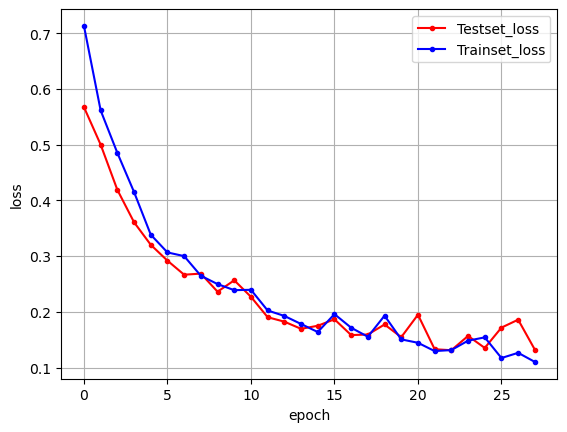

In [9]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()